In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load Spotify song data into a DataFrame
df = pd.read_csv('spotify_songs.csv')

In [ ]:
df.head(5)

In [4]:
genres = df['final genre'].str.get_dummies(sep=',')

In [8]:
genres

,Alternative/Indie,Blues,Country,Electronic/Dance,Folk,Gospel,Hip Hop/Rap,Jazz,Latin,Other,Pop,R&B,Reggae,Rock
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5004,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5005,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5006,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5007,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [10]:
# Select the numerical features to use for clustering
features = ['tempo', 'energy', 'valence','popularity','danceability','instrumentalness', 'acousticness']



In [12]:
df_features = df[features]

In [ ]:
df_features = pd.concat([df_features, genres], axis=1)

In [ ]:
df_features

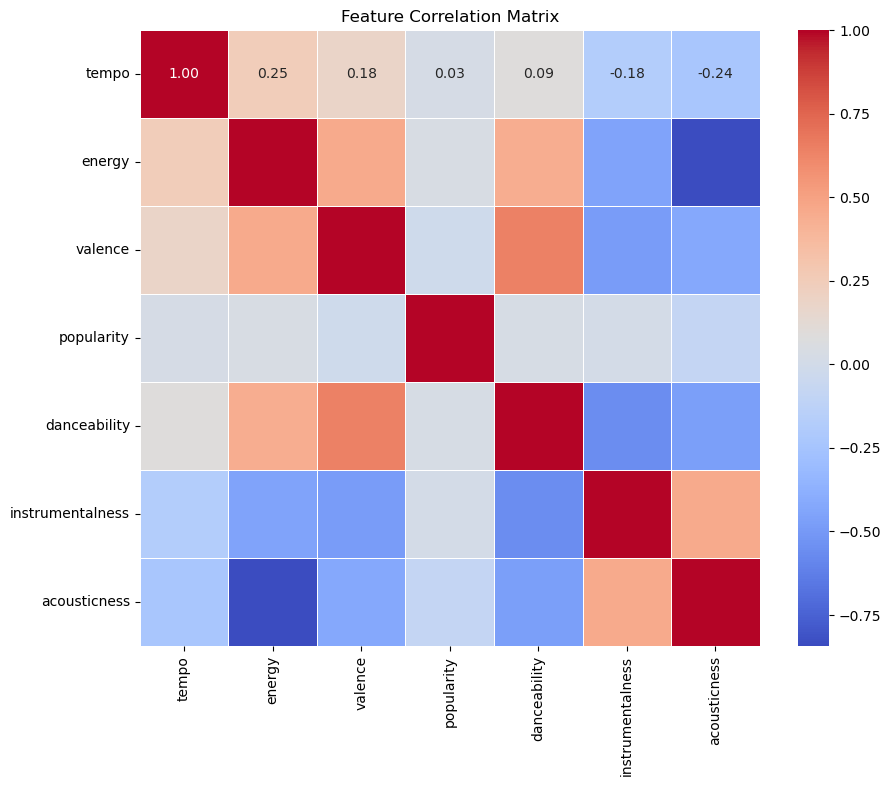

In [14]:

# Calculate the correlation matrix
correlation_matrix = df_features.corr()

# Plot the correlation matrix 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


Danceability and valence are highly correlated - I will remove valence. Popularity can also skew results as there is no relation between the songs just because they are both equally popular. Also energy and accousticness are highly correlated.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


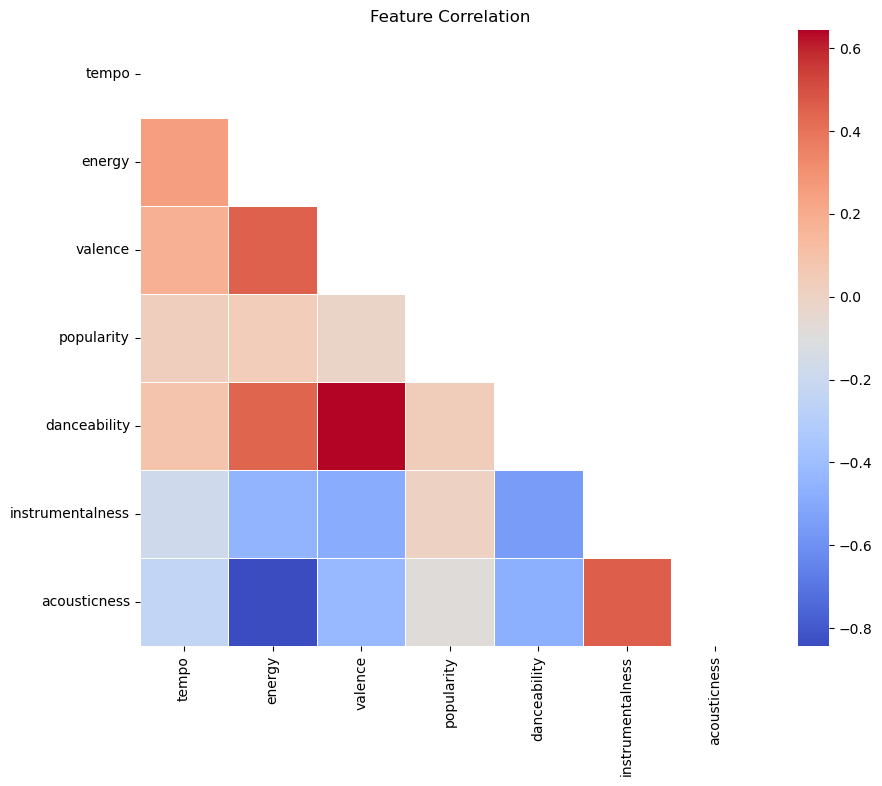

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df_features.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix with the mask applied
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation")
plt.show()


In [ ]:
df_features = df_features.drop(columns=['popularity', 'valence','acousticness','Other'])

In [18]:
df_features = df_features.drop(columns=['popularity', 'valence','acousticness'])

In [20]:
# Standardize the feature values
scaler = MinMaxScaler()
X = scaler.fit_transform(df_features)



In [22]:
# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)



/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

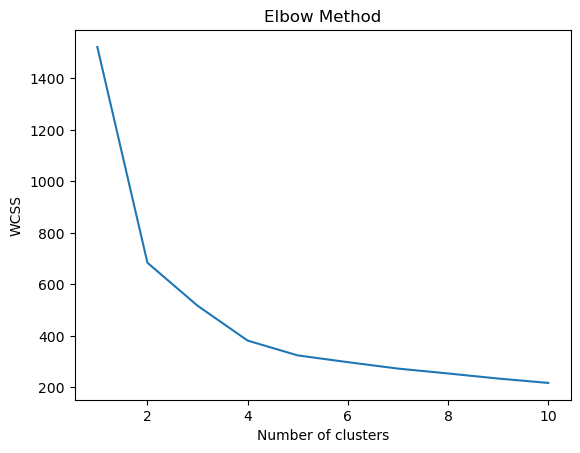

In [24]:
# Plot the elbow curve to find the optimal number of clusters
import matplotlib.pyplot as plt
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



In [26]:
# Perform K-means clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
labels = kmeans.fit_predict(X)



/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


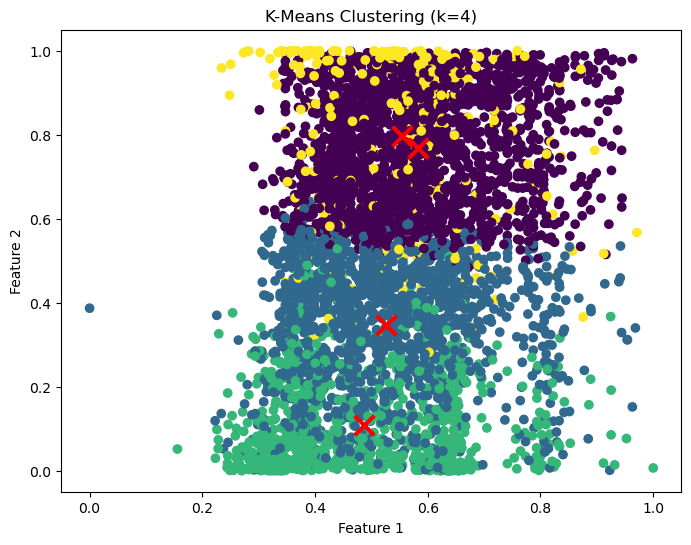

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=200, linewidths=3, color='red')
plt.title(f'K-Means Clustering (k={num_clusters})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA to reduce dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)



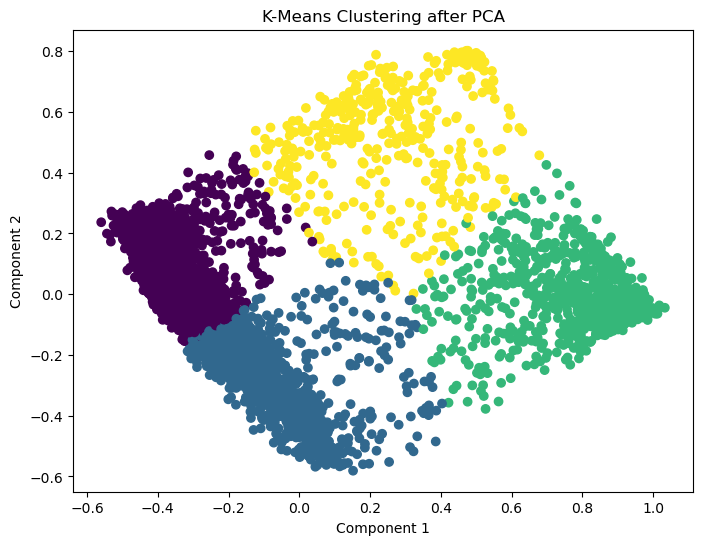

In [32]:
# Visualize the PCA-transformed clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
#plt.scatter(pca.components_[0, 0], pca.components_[0, 1], s=200, linewidths=3, color='red')
#plt.scatter(pca.components_[1, 0], pca.components_[1, 1], s=200, linewidths=3, color='green')
plt.title(f'K-Means Clustering after PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [ ]:
# Add the cluster labels back to the Dataframe
df['cluster'] = labels

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the mean and standard deviation of each feature for each cluster
cluster_stats = []
for cluster_id in range(num_clusters):
    cluster_data = X[labels == cluster_id]
    cluster_mean = cluster_data.mean(axis=0)
    cluster_std = cluster_data.std(axis=0)
    cluster_stats.append({
        'Cluster': cluster_id,
        'Tempo Mean': cluster_mean[0], 
        'Tempo Std': cluster_std[0],
        'Energy Mean': cluster_mean[1],
        'Energy Std': cluster_std[1],
        'Danceability Mean': cluster_mean[2],
        'Danceability Std': cluster_std[2],
        'Instrumentalness Mean': cluster_mean[3],
        'Instrumentalness Std': cluster_std[3]
    })

# Visualize the cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
features = ['Tempo', 'Energy', 'Danceability', 'Instrumentalness']
for i, feature in enumerate(features):
    ax = axes[i // 2, i % 2]
    ax.bar(range(num_clusters), [stats[f"{feature} Mean"] for stats in cluster_stats])
    ax.set_title(f"{feature} Mean by Cluster")
    ax.set_xlabel('Cluster')
    ax.set_ylabel(f"{feature} Mean")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, feature in enumerate(features):
    ax = axes[i // 2, i % 2]
    ax.bar(range(num_clusters), [stats[f"{feature} Std"] for stats in cluster_stats])
    ax.set_title(f"{feature} Std by Cluster")
    ax.set_xlabel('Cluster')
    ax.set_ylabel(f"{feature} Std")

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Compute the feature values for each cluster
cluster_data = []
for cluster_id in range(num_clusters):
    cluster_samples = X[labels == cluster_id]
    cluster_data.append(pd.DataFrame({
        'Cluster': [cluster_id] * len(cluster_samples),
        'Tempo': cluster_samples[:, 0],
        'Energy': cluster_samples[:, 1],
        'Danceability': cluster_samples[:, 2],
        'Instrumentalness': cluster_samples[:, 3]
    }))

# Concatenate the cluster data into a single DataFrame
cluster_df = pd.concat(cluster_data, ignore_index=True)

# Visualize the cluster characteristics using box plots
plt.figure(figsize=(12, 8))
for i, feature in enumerate(['Tempo', 'Energy', 'Danceability', 'Instrumentalness']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Cluster', y=feature, data=cluster_df)
    plt.title(f"{feature} by Cluster")
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Compute the feature values for each cluster
cluster_data = []
for cluster_id in range(num_clusters):
    cluster_samples = X[labels == cluster_id]
    cluster_data.append(pd.DataFrame({
        'Cluster': [cluster_id] * len(cluster_samples),
        'Tempo': cluster_samples[:, 0],
        'Energy': cluster_samples[:, 1],
        'Danceability': cluster_samples[:, 2],
        'Instrumentalness': cluster_samples[:, 3]
    }))

# Concatenate the cluster data into a single DataFrame
cluster_df = pd.concat(cluster_data, ignore_index=True)

# Calculate the mean of each feature per cluster
cluster_means = cluster_df.groupby('Cluster').mean().reset_index()

# Plot overlayed line graphs
plt.figure(figsize=(10, 6))
for feature in ['Tempo', 'Energy', 'Danceability', 'Instrumentalness']:
    plt.plot(cluster_means['Cluster'], cluster_means[feature], marker='o', label=feature)

# Add labels and legend
plt.xlabel('Cluster')
plt.ylabel('Mean Value')
plt.title('Mean Feature Values by Cluster')
plt.legend(title='Features')
plt.grid(True)
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Compute the feature values for each cluster
cluster_data = []
for cluster_id in range(num_clusters):
    cluster_samples = X[labels == cluster_id]
    cluster_data.append(pd.DataFrame({
        'Cluster': [cluster_id] * len(cluster_samples),
        'Tempo': cluster_samples[:, 0],
        'Energy': cluster_samples[:, 1],
        'Danceability': cluster_samples[:, 2],
        'Instrumentalness': cluster_samples[:, 3]
    }))

# Concatenate the cluster data into a single DataFrame
cluster_df = pd.concat(cluster_data, ignore_index=True)

# Visualize the cluster characteristics using violin plots
plt.figure(figsize=(12, 8))
for i, feature in enumerate(['Tempo', 'Energy', 'Danceability', 'Instrumentalness']):
    plt.subplot(2, 2, i+1)
    sns.violinplot(x='Cluster', y=feature, data=cluster_df, inner='quartile', palette='muted')
    plt.title(f"{feature} by Cluster")
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Compute the feature values for each cluster
cluster_data = []
for cluster_id in range(num_clusters):
    cluster_samples = X[labels == cluster_id]
    cluster_data.append(pd.DataFrame({
        'Cluster': [cluster_id] * len(cluster_samples),
        'Tempo': cluster_samples[:, 0],
        'Energy': cluster_samples[:, 1],
        'Danceability': cluster_samples[:, 2],
        'Instrumentalness': cluster_samples[:, 3]
    }))

# Concatenate the cluster data into a single DataFrame
cluster_df = pd.concat(cluster_data, ignore_index=True)

# Melt the DataFrame for easier plotting with Seaborn
cluster_df_melted = cluster_df.melt(id_vars='Cluster', var_name='Feature', value_name='Value')

# Plot violin plots for each cluster, with all features in each plot
plt.figure(figsize=(14, 10))
for cluster_id in range(num_clusters):
    plt.subplot(2, 2, cluster_id + 1)
    sns.violinplot(x='Feature', y='Value', data=cluster_df_melted[cluster_df_melted['Cluster'] == cluster_id], inner='quartile', palette='muted')
    plt.title(f"Cluster {cluster_id} Characteristics")
    plt.xlabel('')
    plt.ylabel('Value')

# Adjust spacing between the rows of charts
plt.subplots_adjust(hspace=5, wspace=0.3) 

plt.tight_layout()
plt.show()


In [ ]:
# Create the popularity_score column
bins = [0, 25, 50, 75, 100]  
labels = ['Low', 'Medium', 'High', 'Highest']

df['popularity_score'] = pd.cut(df['popularity'], bins=bins, labels=labels, right=False)


In [ ]:
#Export to csv
df.to_csv('spotify_songs.csv', index=False)

In [ ]:
df.head(5)